**Homework 9:**



# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "HW9a"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from rdkit.DataStructs import ConvertToNumpyArray

from rdkit.Chem import PandasTools

# Load the data

In [3]:
#
datapath = os.path.join("data/raw", "esol.csv")
esol_data = pd.read_csv(datapath)
esol_data.head()

,cano_smiles,activity,group
0,Cc1occc1C(=O)Nc1ccccc1,-3.30,train
1,CC(C)=CCCC(C)=CC=O,-2.06,train
2,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21,-7.87,train
3,c1ccsc1,-1.33,train
4,c1ccc2scnc2c1,-1.50,train


## Data preprocessing

In [4]:
esol_data.describe()

,activity
count,1127.000000
mean,-3.052010
std,2.096392
min,-11.600000
25%,-4.321000
50%,-2.860000
75%,-1.600000
max,1.580000


In [5]:
#Generate data exploration
esol_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127 entries, 0 to 1126
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cano_smiles  1127 non-null   object 
 1   activity     1127 non-null   float64
 2   group        1127 non-null   object 
dtypes: float64(1), object(2)
memory usage: 26.5+ KB


## Molecule genaration

In [19]:
# Create Mol rdkit objects for each smile
PandasTools.AddMoleculeColumnToFrame(frame=esol_data, smilesCol='cano_smiles', molCol='Molecule')

There are a couple of SMILES that could be parsed by RDKit. For wrong SMILES, rdkit would return 'None'.

In [20]:
sum(esol_data['Molecule'].map(lambda x: x is None))

0

,cano_smiles,activity,group,Molecule,MorgFP
0,Cc1occc1C(=O)Nc1ccccc1,-3.3,train,,"[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."

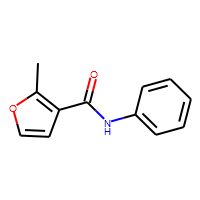

In [21]:
esol_data.head(1)

Text(0.5, 0, 'Heavy atom')

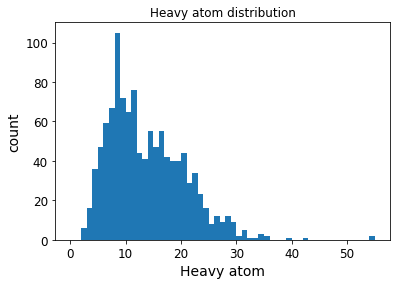

In [32]:
import rdkit
# (esol_data["Molecule"][0]).GetNumHeavyAtoms()

n_heavys = [x.GetNumHeavyAtoms() for x in esol_data["Molecule"]]
import matplotlib.pyplot as plt
plt.hist(n_heavys, bins=range(0, 56))
plt.title("Heavy atom distribution")
plt.ylabel("count")
plt.xlabel("Heavy atom")

In [9]:
#Generate data exploration
esol_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127 entries, 0 to 1126
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cano_smiles  1127 non-null   object 
 1   activity     1127 non-null   float64
 2   group        1127 non-null   object 
 3   Molecule     1127 non-null   object 
dtypes: float64(1), object(3)
memory usage: 35.3+ KB


### Morgan Fingerprint generation
A fingerprint is generated for each compound in the "Molecule" column with a radius of 2 and a bit length of 2048.

In [10]:
#create a column for Morgan fingerprints
n_Bits = 2048
esol_data["MorgFP"] = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits = n_Bits, useFeatures=True) for m in esol_data['Molecule']]## Molecule genaration

In [11]:
esol_data["MorgFP"].head()

0    [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: MorgFP, dtype: object

In [12]:
type(esol_data["MorgFP"])

pandas.core.series.Series

In [13]:
esol_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127 entries, 0 to 1126
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cano_smiles  1127 non-null   object 
 1   activity     1127 non-null   float64
 2   group        1127 non-null   object 
 3   Molecule     1127 non-null   object 
 4   MorgFP       1127 non-null   object 
dtypes: float64(1), object(4)
memory usage: 44.1+ KB


array([[<AxesSubplot:title={'center':'activity'}>]], dtype=object)

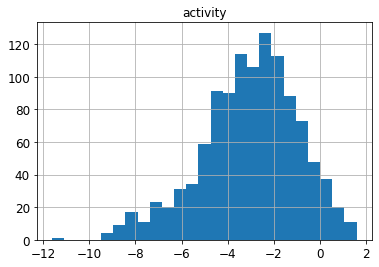

In [18]:
esol_data.hist(bins=25)

## Obtain descriptors

**- DescriptorCalculator(): Various bits and pieces for calculating descriptors.**
**- CalcDescriptors(): 

In [14]:
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
descriptors = list(np.array(Descriptors._descList)[:,0])
print(np.array(Descriptors._descList)[:,0])

['MaxEStateIndex' 'MinEStateIndex' 'MaxAbsEStateIndex' 'MinAbsEStateIndex'
 'qed' 'MolWt' 'HeavyAtomMolWt' 'ExactMolWt' 'NumValenceElectrons'
 'NumRadicalElectrons' 'MaxPartialCharge' 'MinPartialCharge'
 'MaxAbsPartialCharge' 'MinAbsPartialCharge' 'FpDensityMorgan1'
 'FpDensityMorgan2' 'FpDensityMorgan3' 'BCUT2D_MWHI' 'BCUT2D_MWLOW'
 'BCUT2D_CHGHI' 'BCUT2D_CHGLO' 'BCUT2D_LOGPHI' 'BCUT2D_LOGPLOW'
 'BCUT2D_MRHI' 'BCUT2D_MRLOW' 'BalabanJ' 'BertzCT' 'Chi0' 'Chi0n' 'Chi0v'
 'Chi1' 'Chi1n' 'Chi1v' 'Chi2n' 'Chi2v' 'Chi3n' 'Chi3v' 'Chi4n' 'Chi4v'
 'HallKierAlpha' 'Ipc' 'Kappa1' 'Kappa2' 'Kappa3' 'LabuteASA' 'PEOE_VSA1'
 'PEOE_VSA10' 'PEOE_VSA11' 'PEOE_VSA12' 'PEOE_VSA13' 'PEOE_VSA14'
 'PEOE_VSA2' 'PEOE_VSA3' 'PEOE_VSA4' 'PEOE_VSA5' 'PEOE_VSA6' 'PEOE_VSA7'
 'PEOE_VSA8' 'PEOE_VSA9' 'SMR_VSA1' 'SMR_VSA10' 'SMR_VSA2' 'SMR_VSA3'
 'SMR_VSA4' 'SMR_VSA5' 'SMR_VSA6' 'SMR_VSA7' 'SMR_VSA8' 'SMR_VSA9'
 'SlogP_VSA1' 'SlogP_VSA10' 'SlogP_VSA11' 'SlogP_VSA12' 'SlogP_VSA2'
 'SlogP_VSA3' 'SlogP_VSA4' 'SlogP_VS

In [15]:
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptors)
# Define a custom function to calculate molecular descriptors
def computeDescriptors(mol, calculator):
    res = list(calculator.CalcDescriptors(mol))
    if not np.all(np.isfinite(res)):
        return None  
# Make it's easier to identify problematic molecules (e.g.: infinty descriptor values) later 
    return res

,cano_smiles,activity,group,Molecule,MorgFP,Descriptors
0,Cc1occc1C(=O)Nc1ccccc1,-3.30,train,,"[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[11.724911186696902, -0.14587962962962941, 11...."
1,CC(C)=CCCC(C)=CC=O,-2.06,train,,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[10.020497606449988, 0.8450897581254724, 10.02..."
2,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21,-7.87,train,,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.270277777777778, 1.3010547891996307, 2.2702..."
3,c1ccsc1,-1.33,train,,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.0416666666666665, 1.7129629629629628, 2.041..."
4,c1ccc2scnc2c1,-1.50,train,,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4.137222222222222, 1.0995370370370372, 4.1372..."

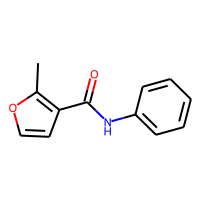
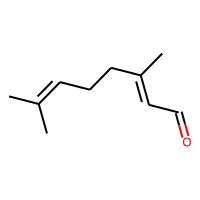
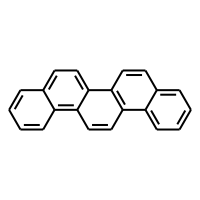
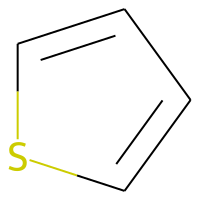
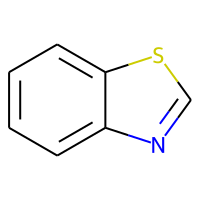

In [16]:
# Compute the descriptors
esol_data['Descriptors'] = esol_data['Molecule'].map(lambda x: computeDescriptors(x,calculator))
# Remove rows with non-finite descriptor values (seems to be only 1 by comparing the counts)
esol_data = esol_data[esol_data['Descriptors'].map(lambda x: x is not None)]
esol_data.head()

In [17]:
df_descriptors = pd.DataFrame(descriptors, columns=['desc_name'])
df_descriptors

,desc_name
0,MaxEStateIndex
1,MinEStateIndex
2,MaxAbsEStateIndex
3,MinAbsEStateIndex
4,qed
...,...
203,fr_thiazole
204,fr_thiocyan
205,fr_thiophene
206,fr_unbrch_alkane


In [18]:
desc_name = [df_descriptors['desc_name'][i] for i in range(len(df_descriptors))]
desc_val = [list(l) for l in esol_data['Descriptors']]
df_desc = pd.DataFrame(desc_val, index = esol_data.index, columns=desc_name)
df_desc.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.724911,-0.145880,11.724911,0.145880,0.811283,201.225,190.137,201.078979,76,0,...,0,0,0,0,0,0,0,0,0,0
1,10.020498,0.845090,10.020498,0.845090,0.343706,152.237,136.109,152.120115,62,0,...,0,0,0,0,0,0,0,0,0,0
2,2.270278,1.301055,2.270278,1.301055,0.291526,278.354,264.242,278.109550,102,0,...,0,0,0,0,0,0,0,0,0,0
3,2.041667,1.712963,2.041667,1.712963,0.448927,84.143,80.111,84.003371,26,0,...,0,0,0,0,0,0,0,1,0,0
4,4.137222,1.099537,4.137222,1.099537,0.539774,135.191,130.151,135.014270,44,0,...,0,0,0,0,0,1,0,0,0,0


In [19]:
esol = pd.concat([esol_data, df_desc], axis= 1, ignore_index=False)


In [20]:
esol.shape

(1127, 214)

,cano_smiles,activity,group,Molecule,MorgFP,Descriptors,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,Cc1occc1C(=O)Nc1ccccc1,-3.30,train,,"[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[11.724911186696902, -0.14587962962962941, 11....",11.724911,-0.145880,11.724911,0.145880,...,0,0,0,0,0,0,0,0,0,0
1,CC(C)=CCCC(C)=CC=O,-2.06,train,,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[10.020497606449988, 0.8450897581254724, 10.02...",10.020498,0.845090,10.020498,0.845090,...,0,0,0,0,0,0,0,0,0,0
2,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21,-7.87,train,,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.270277777777778, 1.3010547891996307, 2.2702...",2.270278,1.301055,2.270278,1.301055,...,0,0,0,0,0,0,0,0,0,0
3,c1ccsc1,-1.33,train,,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.0416666666666665, 1.7129629629629628, 2.041...",2.041667,1.712963,2.041667,1.712963,...,0,0,0,0,0,0,0,1,0,0
4,c1ccc2scnc2c1,-1.50,train,,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4.137222222222222, 1.0995370370370372, 4.1372...",4.137222,1.099537,4.137222,1.099537,...,0,0,0,0,0,1,0,0,0,0

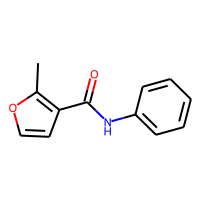
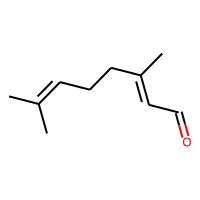
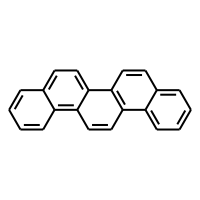
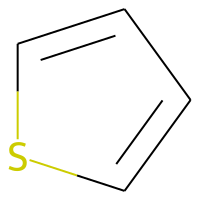
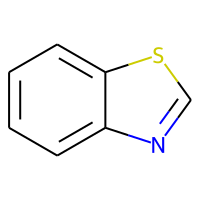

In [21]:
esol.head()

In [22]:
len(esol)

1127

In [23]:
esol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1127 entries, 0 to 1126
Columns: 214 entries, cano_smiles to fr_urea
dtypes: float64(105), int64(104), object(5)
memory usage: 1.8+ MB


In [24]:
#Finds Null data in any row if any
sample_incomplete_rows = esol[esol.isnull().any(axis=1)]
sample_incomplete_rows.head(len(sample_incomplete_rows))

,cano_smiles,activity,group,Molecule,MorgFP,Descriptors,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea


In [25]:
esol.describe()

,activity,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,1127.000000,1127.000000,1127.000000,1127.000000,1.127000e+03,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,...,1127.000000,1127.000000,1127.000000,1127.000000,1127.0,1127.000000,1127.0,1127.000000,1127.000000,1127.000000
mean,-3.052010,8.244967,-0.181956,8.244967,4.878957e-01,0.553054,204.103795,191.650031,203.628466,72.113576,...,0.030169,0.021295,0.003549,0.013310,0.0,0.006211,0.0,0.001775,0.301686,0.073647
std,2.096392,3.701188,1.295477,3.701188,4.904214e-01,0.149158,102.630917,99.215618,102.296535,36.119417,...,0.171127,0.167228,0.059496,0.114648,0.0,0.078601,0.0,0.042108,1.408370,0.274569
min,-11.600000,1.500000,-5.573220,1.500000,2.220446e-16,0.146432,26.038000,24.022000,26.015650,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
25%,-4.321000,5.057006,-0.608382,5.057006,1.076259e-01,0.451039,121.651500,112.087000,121.531131,44.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
50%,-2.860000,9.188226,-0.046343,9.188226,3.078704e-01,0.533979,182.179000,172.103000,182.079038,64.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
75%,-1.600000,11.483477,0.738474,11.483477,7.945370e-01,0.648945,270.372000,257.068000,270.161980,94.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
max,1.580000,17.262020,4.000000,17.262020,4.000000e+00,0.934235,780.949000,716.437000,780.429607,312.000000,...,1.000000,2.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,21.000000,2.000000


In [26]:
esol.to_csv("data/processed/esol_full.csv")

### Splitting and Visualizing the data

In [27]:
#Finds Null data in any row if any
sample_incomplete_rows = esol[esol_data.isnull().any(axis=1)]
sample_incomplete_rows.head(len(sample_incomplete_rows))

,cano_smiles,activity,group,Molecule,MorgFP,Descriptors,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea


In [28]:
#Returns number of unique values in the specifed column to make sure that no duplications there
esol['cano_smiles'].nunique()

1116

In [29]:
#Returns number of total rows
esol['cano_smiles'].count()

1127

In [30]:
#Drops the duplicated ones
esol = esol.drop_duplicates(['cano_smiles'])

In [31]:
esol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1116 entries, 0 to 1126
Columns: 214 entries, cano_smiles to fr_urea
dtypes: float64(105), int64(104), object(5)
memory usage: 1.8+ MB


# Splite the data


In [32]:
#Returns the training set
train = esol[esol["group"]=="train"]
len(train)

893

In [33]:
#Returns the test set
test = esol[esol["group"]=="test"]
len(test)

112

In [34]:
#Returns the valid set
valid = esol[esol["group"]=="valid"]
len(valid)

111

,cano_smiles,activity,group,Molecule,MorgFP,Descriptors,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,Cc1occc1C(=O)Nc1ccccc1,-3.300,train,,"[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[11.724911186696902, -0.14587962962962941, 11....",11.724911,-0.145880,11.724911,0.145880,...,0,0,0,0,0,0,0,0,0,0
1,CC(C)=CCCC(C)=CC=O,-2.060,train,,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[10.020497606449988, 0.8450897581254724, 10.02...",10.020498,0.845090,10.020498,0.845090,...,0,0,0,0,0,0,0,0,0,0
2,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21,-7.870,train,,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.270277777777778, 1.3010547891996307, 2.2702...",2.270278,1.301055,2.270278,1.301055,...,0,0,0,0,0,0,0,0,0,0
3,c1ccsc1,-1.330,train,,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.0416666666666665, 1.7129629629629628, 2.041...",2.041667,1.712963,2.041667,1.712963,...,0,0,0,0,0,0,0,1,0,0
4,c1ccc2scnc2c1,-1.500,train,,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4.137222222222222, 1.0995370370370372, 4.1372...",4.137222,1.099537,4.137222,1.099537,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,FC(F)(F)C(Cl)Br,-1.710,train,,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[10.999421296296298, -4.317901234567901, 10.99...",10.999421,-4.317901,10.999421,1.916667,...,0,0,0,0,0,0,0,0,0,0
897,CNC(=O)ON=C(SC)C(=O)N(C)C,0.106,train,,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[11.337508030990174, -0.705457294028722, 11.33...",11.337508,-0.705457,11.337508,0.123704,...,1,0,0,0,0,0,0,0,0,0
898,CCSCCSP(=S)(OC)OC,-3.091,train,,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5.174287131519274, -1.9846619110607204, 5.174...",5.174287,-1.984662,5.174287,1.011373,...,1,0,0,0,0,0,0,0,2,0
899,CCC(C)C,-3.180,train,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.2222222222222223, 0.8842592592592591, 2.222...",2.222222,0.884259,2.222222,0.884259,...,0,0,0,0,0,0,0,0,0,0

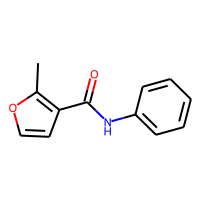
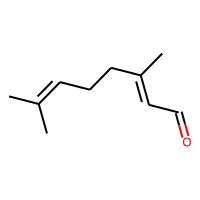
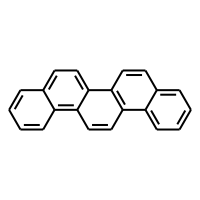
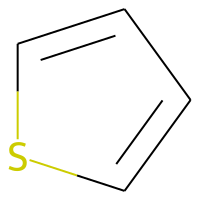
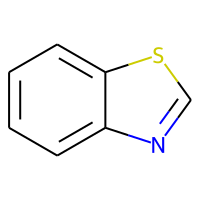
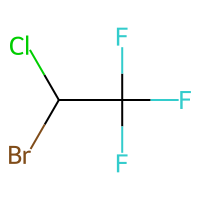
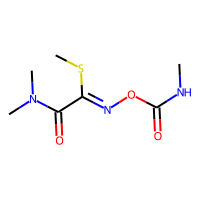
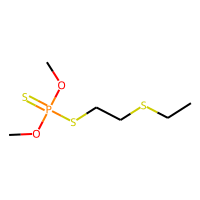
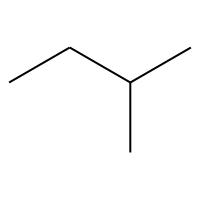
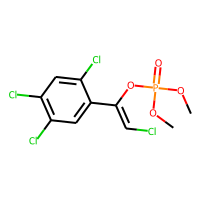

In [35]:
train

In [36]:
# Specifing the columns for dependent and independent variables (Training dataset)
X_train = train.drop(["cano_smiles","activity", "group", "Molecule", "Descriptors","MorgFP"], axis = 1).values
y_train = train["activity"].values

In [37]:
# Specifing the columns for dependent and independent variables (Test dataset)
X_test = test.drop(["cano_smiles","activity", "group", "Molecule", "Descriptors","MorgFP"], axis = 1).values
y_test = test["activity"].values

In [38]:
# Specifing the columns for dependent and independent variables (Validation dataset)
X_valid = valid.drop(["cano_smiles","activity", "group", "Molecule", "Descriptors","MorgFP"], axis = 1).values
y_valid = valid["activity"].values

**Convert the RDKit explicit vectors into numpy arrays**

In [39]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_valid = np.array(X_valid)

In [40]:
print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))
print(type(X_valid))
print(type(y_valid))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Feature Scaling

In [41]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)
X_test = sc.transform(X_test)

## XGboost Regressor

In [42]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)
model = xgb.fit(X_train, y_train)


In [43]:
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 1,
 'num_parallel_tree': 1,
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

### Training dataset

In [44]:
from sklearn.metrics import mean_squared_error

y_train_pred = model.predict(X_train)
xgb_mse = mean_squared_error(y_train, y_train_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

/ext3/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


0.01460675860887739

### Validation dataset

In [45]:
y_valid_pred = model.predict(X_valid)
xgb_mse = mean_squared_error(y_valid, y_valid_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

/ext3/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


0.6464479238609873

### Test dataset

In [46]:
y_test_pred = model.predict(X_test)
xgb_mse = mean_squared_error(y_test, y_test_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

/ext3/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


0.5657269812121349

# Grid search:

In [47]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'gamma': [0.001, 0.01, 0.1, 0.7],
    'min_child_weight': range(1, 10, 3),
    'subsample': np.arange(0.1, 1.0, 0.3),
    'colsample_bytree': np.arange(0.1, 1.0, 0.3),
    'max_depth': range(3, 10, 3),
    'n_estimators': range(200, 1000, 200)
        }

In [48]:
from sklearn.model_selection import ParameterGrid
grid = ParameterGrid(param_grid)

In [49]:
len(grid)

3888

In [50]:
import warnings
warnings.filterwarnings("ignore")

In [60]:
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

best_model = None
best_rmse=np.inf
best_param = {}
for this_param in tqdm(grid):
    this_model = XGBRegressor(**this_param, random_state=42)
    this_model.fit(X_train, y_train)
#     print(this_model.predict(X_valid))
    y_pred = this_model.predict(X_valid)
    xgb_mse = mean_squared_error(y_valid, y_pred)
    xgb_rmse = np.sqrt(xgb_mse)
    if best_rmse > xgb_rmse:
        best_model = this_model
        best_rmse = xgb_rmse
        best_param = this_param
        

100%|██████████| 3888/3888 [2:03:15<00:00,  1.90s/it]  


In [61]:
print(best_param)

{'colsample_bytree': 0.4, 'gamma': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 200, 'subsample': 0.1}


### Training dataset

In [62]:
y_train_pred = best_model.predict(X_train)

In [63]:
xgb_mse = mean_squared_error(y_train, y_train_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

0.46810674624290965

### Validation dataset

In [64]:
y_valid_pred =best_model.predict(X_valid)

In [65]:
xgb_mse = mean_squared_error(y_valid, y_valid_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

0.5292465223845259

### Test dataset

In [66]:
y_test_pred = best_model.predict(X_test)

In [67]:
xgb_mse = mean_squared_error(y_test, y_test_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

0.544199569789415

In [68]:
print("Done")

Done
